# Mapy statyczne

***Autor: Adam Dąbkowski***

## 0. Importowanie niezbędnych bibliotek

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. Wczytywanie zbioru danych

Źródło danych: ***https://www.kaggle.com/datasets/dianaddx/global-power-plant-database/data***

In [2]:
DATASET_PATH: str = "GlobalPowerPlantDB.csv"

In [3]:
df = pd.read_csv(DATASET_PATH, low_memory=False)

In [4]:
df_poland = df[df["country_long"] == "Poland"]
df_poland.head(n=1000)

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
18437,POL,Poland,Bełchatów,WRI1023817,5472.0,51.2679,19.3265,Coal,NaN,NaN,...,NaN,NaN,NaN,NaN,22729.96,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
18438,POL,Poland,Bielkowo,WRI1061573,7.0,54.2695,18.5100,Hydro,NaN,NaN,...,16.09,19.36,9.53,19.41,18.77,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
18439,POL,Poland,Blachownia,WRI1019069,158.0,50.3562,18.2907,Gas,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION
18440,POL,Poland,Brąswałd,WRI1061574,2.0,53.8400,20.4041,Hydro,NaN,NaN,...,7.67,9.03,5.56,8.35,8.09,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
18441,POL,Poland,CEZ Skawina,WRI1019052,330.0,49.9767,19.8047,Coal,NaN,NaN,...,NaN,NaN,NaN,NaN,1370.77,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18621,POL,Poland,Łapino,WRI1061576,7.0,54.2847,18.4482,Hydro,NaN,NaN,...,16.09,19.36,9.53,19.41,18.77,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
18622,POL,Poland,Łaziska,WRI1019041,1155.0,50.1331,18.8465,Coal,Biomass,NaN,...,NaN,NaN,NaN,NaN,4797.71,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
18623,POL,Poland,Żagań II,WRI1061549,2.0,51.6154,15.3168,Hydro,NaN,NaN,...,7.76,8.66,6.60,8.71,8.27,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
18624,POL,Poland,Żarnowiec,WRI1019043,716.0,54.7224,18.0825,Hydro,NaN,NaN,...,1789.14,2488.13,1293.63,2494.95,1789.14,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


## 2. Wizualizacja danych

#### 2.1 Wizualizacja lokalizacji elektrowni na mapie

In [5]:
POLAND_GEOJSON_PATH: str = "poland.geojson"
poland_map = gpd.read_file(POLAND_GEOJSON_PATH)

In [14]:
gdf_poland = gpd.GeoDataFrame(
    df_poland,
    geometry=gpd.points_from_xy(df_poland.longitude, df_poland.latitude),
    crs="EPSG:4326"
)

In [ ]:
counts = df_poland['primary_fuel'].value_counts()
df_poland['primary_fuel'] = pd.Categorical(
    df_poland['primary_fuel'], categories=counts.index, ordered=True
)

grouped_data = df_poland.groupby('primary_fuel')['capacity_mw'].sum().reset_index()
grouped_data = grouped_data.copy()

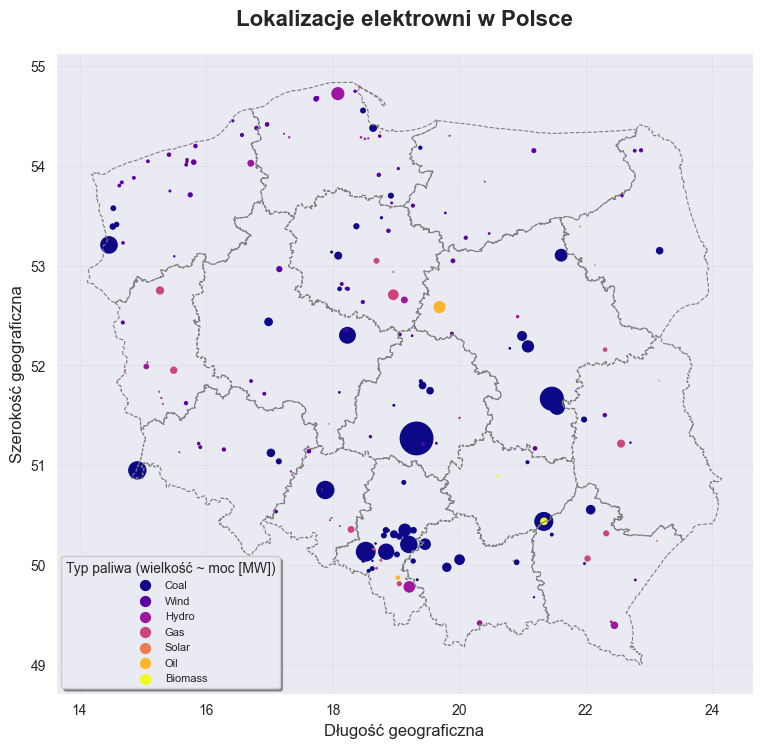

In [23]:
fig, ax = plt.subplots(figsize=(9, 9))

fig.patch.set_alpha(0.0)

poland_map.boundary.plot(ax=ax, linewidth=0.8, color="gray", linestyle='--')

fuel_types = grouped_data['primary_fuel']
color_map = cm.plasma(np.linspace(0, 1, len(fuel_types)))
color_dict = dict(zip(fuel_types, color_map))

for fuel in fuel_types:
    subset = gdf_poland[gdf_poland['primary_fuel'] == fuel]
    subset.plot(
        ax=ax,
        color=color_dict[fuel],
        markersize=subset['capacity_mw'] * 0.1,
    )

ax.set_title("Lokalizacje elektrowni w Polsce", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Długość geograficzna", fontsize=12)
ax.set_ylabel("Szerokość geograficzna", fontsize=12)

ax.grid(color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

for fuel in fuel_types:
    ax.scatter([], [], color=color_dict[fuel], s=50, label=f"{fuel}")

ax.legend(
    fontsize=8,
    loc='lower left',
    frameon=True,
    fancybox=True,
    shadow=True,
    title="Typ paliwa (wielkość ~ moc [MW])"
)

plt.show()

#### 2.2 Wizualizacja danych w zależności od typu elektrowni

##### Histogramy

In [ ]:
counts = df_poland['primary_fuel'].value_counts()
df_poland['primary_fuel'] = pd.Categorical(df_poland['primary_fuel'], categories=counts.index, ordered=True)

grouped_data = df_poland.groupby('primary_fuel')['capacity_mw'].sum().reset_index()
grouped_data = grouped_data.copy()

total_power = grouped_data['capacity_mw'].sum()
grouped_data['percentage'] = (grouped_data['capacity_mw'] / total_power) * 100

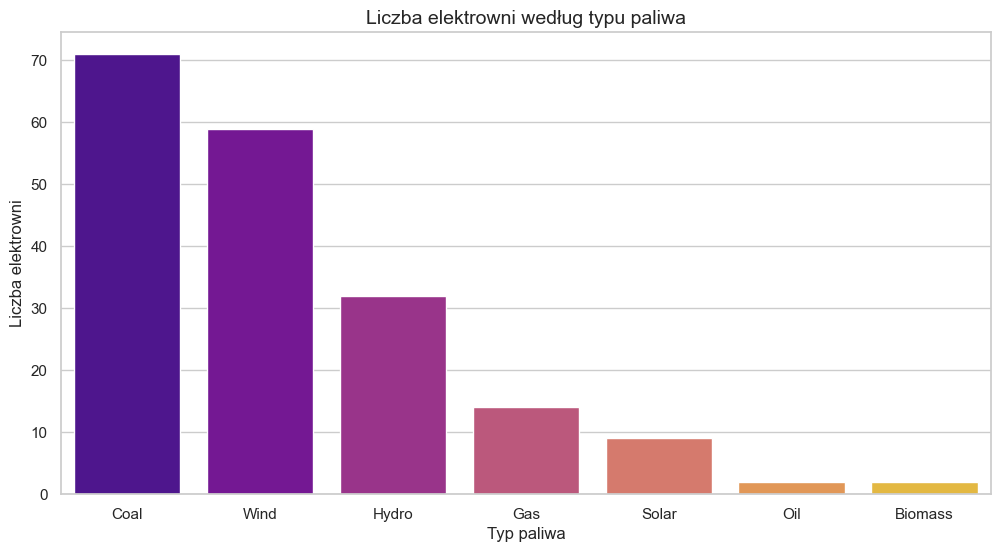

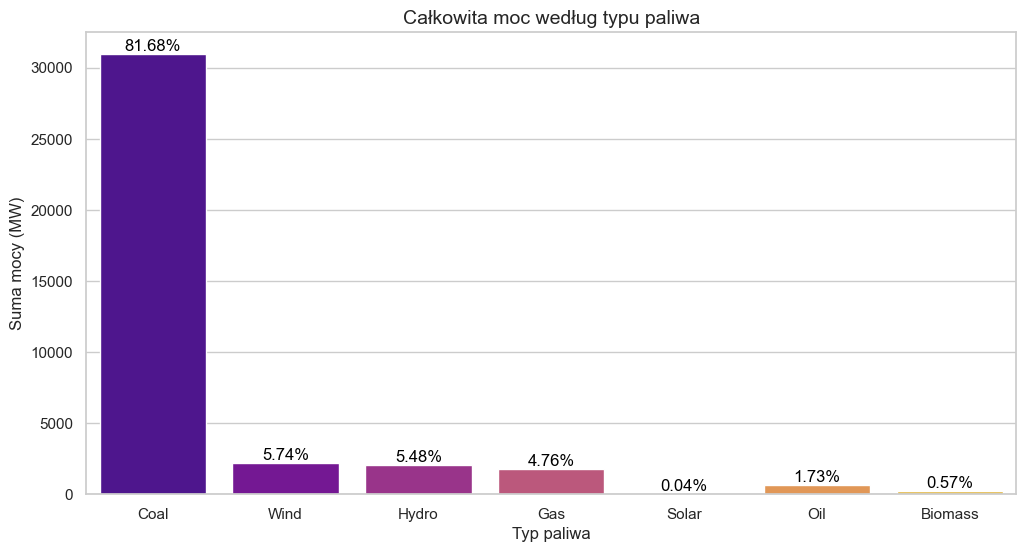

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.gcf().patch.set_alpha(0.0)
sns.countplot(data=df_poland, x='primary_fuel', hue='primary_fuel', palette='plasma')
plt.title('Liczba elektrowni według typu paliwa', fontsize=14)
plt.xlabel('Typ paliwa', fontsize=12)
plt.ylabel('Liczba elektrowni', fontsize=12)
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.gcf().patch.set_alpha(0.0)
barplot = sns.barplot(data=grouped_data, x='primary_fuel', hue='primary_fuel', y='capacity_mw', palette='plasma')
plt.title('Całkowita moc według typu paliwa', fontsize=14)
plt.xlabel('Typ paliwa', fontsize=12)
plt.ylabel('Suma mocy (MW)', fontsize=12)

for index, row in grouped_data.iterrows():
    barplot.text(index, row['capacity_mw'], f'{row["percentage"]:.2f}%', color='black', ha="center", va='bottom')

plt.show()

##### Wykresy kołowe

In [28]:
power_grouped = df_poland.groupby('primary_fuel', observed=False)['capacity_mw'].sum()
count_grouped = df_poland['primary_fuel'].value_counts()

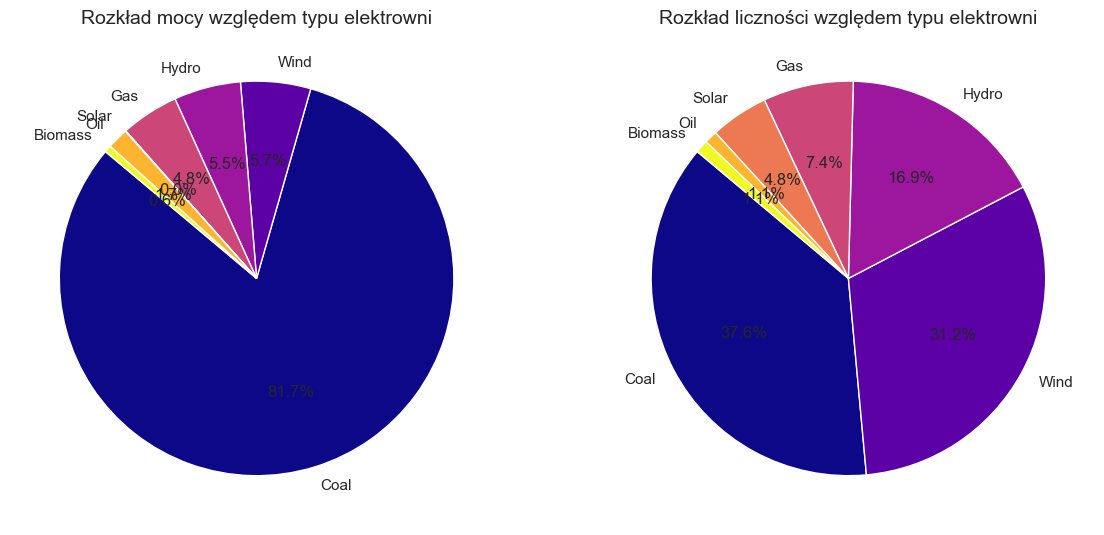

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

fig.patch.set_alpha(0.0)

ax[0].pie(power_grouped, labels=power_grouped.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.plasma(np.linspace(0, 1, len(power_grouped))))
ax[0].set_title('Rozkład mocy względem typu elektrowni', fontsize=14)

ax[1].pie(count_grouped, labels=count_grouped.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.plasma(np.linspace(0, 1, len(count_grouped))))
ax[1].set_title('Rozkład liczności względem typu elektrowni', fontsize=14)

plt.show()